# CalTech 101 - CNN 

## All Imports 

In [12]:
import os
import cv2
import numpy as np
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Dropout, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.inception_v3 import InceptionV3


## Data Loading


In [3]:
def extract_dataset(dataset_file_path, extraction_directory):
    os.makedirs(extraction_directory, exist_ok=True)
    with tarfile.open(dataset_file_path) as tar:
        tar.extractall(path=extraction_directory)
    print("Done")

extract_dataset('./dataset.tgz','./data/')

Done


## Examining dataset

In [ ]:
def get_image(object_category, data_directory):
    data_directory = os.path.abspath(data_directory)
    obj_category_dir = os.path.join(data_directory, "101_ObjectCategories", object_category)

    if not os.path.exists(obj_category_dir):
        print(f"Object category directory {obj_category_dir} not found.")
        return

    images = [os.path.join(obj_category_dir, img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Resize and read individual images - The average image size in Caltech 101 is 300x200, so adjustments are made accordingly."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300, 200), interpolation=cv2.INTER_CUBIC)
    return img

In [180]:
def get_image(object_category, data_directory):
    data_directory = os.path.abspath(data_directory)
    obj_category_dir = os.path.join(data_directory, "101_ObjectCategories", object_category)

    if not os.path.exists(obj_category_dir):
        print(f"Object category directory {obj_category_dir} not found.")
        return

    images = [os.path.join(obj_category_dir, img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Resize and read individual images - The average image size in Caltech 101 is 300x200, so adjustments are made accordingly."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300, 200), interpolation=cv2.INTER_CUBIC)
    return img

In [5]:
dolphin_img = get_image('dolphin','./data')

In [6]:
dolphin_img[0]

'./data/101_ObjectCategories/dolphin/image_0012.jpg'

In [7]:
dolphin_test_img = read_image(dolphin_imgs[0])

In [8]:
dolphin_test_img.shape

(200, 300, 3)

#### Finding image count for each category

In [181]:
def get_image_counts_by_category(data_directory):
    categories_dir = os.path.join(data_directory, "101_ObjectCategories")
    categories = os.listdir(categories_dir)
    object_images_count_dict = {category: len(os.listdir(os.path.join(categories_dir, category))) for category in categories}
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [10]:
get_image_counts_by_category('./data')

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('kangaroo', 86),
 ('starfish', 86),
 ('trilobite', 86),
 ('ewer', 85),
 ('sunflower', 85),
 ('buddha', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('electric_guitar', 75),
 ('umbrella', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('flamingo', 67),
 ('dalmatian', 67),
 ('ferry', 67),
 ('lotus', 66),
 ('dolphin', 65),
 ('elephant', 64),
 ('stop_sign', 64),
 ('joshua_tree', 64),
 ('soccer_ball', 64),
 ('euphonium', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('rhino', 59),
 ('wheelchair', 59),
 ('stegosaurus', 59),
 (

In [11]:
len(get_image_counts_by_category('./data'))

102

The `BACKGROUND_Google` directory in the Caltech 101 dataset is typically used for negative samples (i.e., images that don't belong to any of the other 101 categories). For the purpose of your assignment, we'll focus solely on the 101 object categories.

### Total Image Count

In [12]:
def get_total_image_count(data_directory):
    total_count = sum(count for category, count in return_images_per_category(data_directory) 
                      if category != 'BACKGROUND_Google')
    return total_count

print(f"Total number of images in training data: {get_total_image_count('./data')}")

Total number of images in training data :  8677


In [182]:
def create_training_data(data_directory):
    image_paths = [
        image
        for category, _ in return_images_per_category(data_directory)
        if category != 'BACKGROUND_Google'
        for image in get_images(category, data_directory)
        if image.endswith('.jpg')
    ]

    num_images = len(image_paths)
    X = np.empty((num_images, 200, 300, 3), dtype=np.uint8)
    Y = []

    print(f"Preparing X and Y for dataset with {num_images} images...")

    for i, image_path in enumerate(image_paths):
        category = image_path.split(os.sep)[-2]  # Extract category from the image path
        print(f"Processing image {i + 1} of {num_images} from category {category}...")

        X[i] = read_image(image_path)
        Y.append(category)

        print(f"Images processed: {i + 1} of {num_images}")

    print("Datasets constructed")
    return X, Y

In [183]:
X, Y = create_training_data('./data')

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  Motorbikes
Images processed :  1599  of 8678
Processing images of  Faces
Images processed :  2034  of 8678
Processing images of  Faces_easy
Images processed :  2469  of 8678
Processing images of  watch
Images processed :  2708  of 8678
Processing images of  Leopards
Images processed :  2908  of 8678
Processing images of  bonsai
Images processed :  3036  of 8678
Processing images of  car_side
Images processed :  3159  of 8678
Processing images of  ketch
Images processed :  3273  of 8678
Processing images of  chandelier
Images processed :  3380  of 8678
Processing images of  hawksbill
Images processed :  3480  of 8678
Processing images of  grand_piano
Images processed :  3579  of 8678
Processing images of  brain
Images processed :  3677  of 8678
Processing images of  butterfly
Images processed :  3768  of 8678
Processing images of  helicopter
Images processed :  3856  o

**Verifying Dataset Integrity**

In [15]:
X.shape

(8677, 200, 300, 3)

Random sample check to verify

In [16]:
Y[2323]

'Faces_easy'

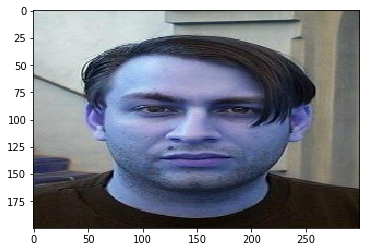

In [17]:
imshow(X[2323])

In [18]:
Y[1001]

'Motorbikes'

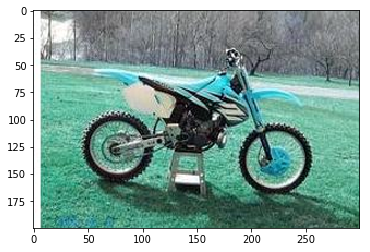

In [19]:
imshow(X[1001])

### Convert categorical labels to one-hot encoded format:

In [184]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([ 5,  5,  5, ..., 52, 52, 52])

In [187]:
np.save('label_encoder.npy', label_encoder.classes_)

In [21]:
len(Y_integer_encoded)

8677

In [22]:
len(Y)

8677

In [23]:
len(X)

8677

In [26]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [25]:
Y_one_hot[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [26]:
len(Y_one_hot[0])

101

### Normalizing the images

In [27]:
X_normalized = X.astype(np.float64) / 255

In [28]:
X[0]

array([[[126, 117, 114],
        [129, 120, 117],
        [130, 121, 118],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[126, 117, 114],
        [129, 120, 117],
        [130, 121, 118],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[127, 118, 115],
        [130, 121, 118],
        [131, 122, 119],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[ 81, 113, 130],
        [ 80, 112, 129],
        [ 80, 110, 128],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 84, 117, 133],
        [ 79, 113, 128],
        [ 79, 110, 126],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 87, 122, 136],
        [ 79, 115, 128],
        [ 78, 111, 126],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

In [29]:
X_normalized[0]

array([[[ 0.49411765,  0.45882353,  0.44705882],
        [ 0.50588235,  0.47058824,  0.45882353],
        [ 0.50980392,  0.4745098 ,  0.4627451 ],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 0.49411765,  0.45882353,  0.44705882],
        [ 0.50588235,  0.47058824,  0.45882353],
        [ 0.50980392,  0.4745098 ,  0.4627451 ],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 0.49803922,  0.4627451 ,  0.45098039],
        [ 0.50980392,  0.4745098 ,  0.4627451 ],
        [ 0.51372549,  0.47843137,  0.46666667],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       ..., 
       [[ 0.31764706,  0.44313725,  0.50980392],
        

In [30]:
# Since X is no longer needed, let's deallocate the memory it's using
del X

### Splitting the dataset

In [31]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)

In [32]:
X_train.shape

(6507, 200, 300, 3)

In [33]:
Y_train.shape

(6507, 101)

# Model Architectures

## 1. Custom CNN Architecture

**Defining Model Architecture**

In [103]:
def create_cnn():
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(pool_size=2, strides=2),
        Conv2D(64, (3,3), activation='relu'),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=2, strides=2),
        Flatten(),
        Dense(101, activation='softmax')
    ])
    return model

model_cnn = create_cnn()
model_cnn.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 198, 298, 16)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 296, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 98, 148, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 146, 64)       18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 94, 144, 128)      73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 72, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 433152)            0         
__________

**Defining Loss and Optimizer**

In [104]:
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [41]:
def train_model(model, X_train, Y_train, X_validation, Y_validation):
    callbacks_list = [
        ModelCheckpoint(filepath='cnn_model.h5', monitor='val_acc', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
    ]
    history = model.fit(
        x=X_train, 
        y=Y_train, 
        batch_size=64, 
        epochs=30, 
        verbose=1, 
        validation_data=(X_validation, Y_validation), 
        callbacks=callbacks_list
    )
    return history

history = train_model(model_cnn, X_train, Y_train, X_validation, Y_validation)

Train on 6507 samples, validate on 2170 samples
Epoch 1/30
6507/6507 [==============================] - 88s - loss: 3.2295 - acc: 0.3418 - val_loss: 2.1935 - val_acc: 0.5171
Epoch 2/30
6507/6507 [==============================] - 87s - loss: 0.7872 - acc: 0.8102 - val_loss: 2.1884 - val_acc: 0.5820
Epoch 3/30
6507/6507 [==============================] - 87s - loss: 0.0550 - acc: 0.9885 - val_loss: 3.1001 - val_acc: 0.5848
Epoch 4/30
6507/6507 [==============================] - 109s - loss: 0.0186 - acc: 0.9966 - val_loss: 2.8251 - val_acc: 0.5968
Epoch 5/30
6507/6507 [==============================] - 86s - loss: 0.0086 - acc: 0.9995 - val_loss: 3.1758 - val_acc: 0.6023
Epoch 6/30
6507/6507 [==============================] - 85s - loss: 0.0104 - acc: 0.9983 - val_loss: 3.3237 - val_acc: 0.5714
Epoch 7/30
6507/6507 [==============================] - 85s - loss: 0.0170 - acc: 0.9963 - val_loss: 3.7011 - val_acc: 0.5548
Epoch 00006: early stopping


The observation above indicates that overfitting has occurred. To mitigate overfitting, we could explore the following techniques:

* Dropout
* L2 regularization

## 2. CNN Model with Dropout

In [37]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 300, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=2, strides=2),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=2, strides=2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(101, activation='softmax')
    ])
    return model

def compile_model(model):
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

def train_model(model, X_train, Y_train, X_validation, Y_validation):
    callbacks_list = [
        ModelCheckpoint(filepath='cnn_model_dropout_two.h5', monitor='val_acc', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
    ]
    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=16,
        epochs=10,
        verbose=1,
        validation_data=(X_validation, Y_validation),
        callbacks=callbacks_list
    )
    return history

model_cnn_dropout = create_model()
compile_model(model_cnn_dropout)
history = train_model(model_cnn_dropout, X_train, Y_train, X_validation, Y_validation)
model_cnn_dropout.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 298, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 296, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 148, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 146, 64)       18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 94, 144, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 72, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 216576)            0         
__________

## 3. Transfer learning using InceptionV3

In [14]:
def build_transfer_learning_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(101, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

def freeze_layers(model, trainable_from_layer):
    for layer in model.layers[:trainable_from_layer]:
        layer.trainable = False
    for layer in model.layers[trainable_from_layer:]:
        layer.trainable = True

In [15]:
transfer_learning_model = build_transfer_learning_model()
freeze_layers(transfer_learning_model, 280)

transfer_learning_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_283 (Conv2D)              (None, None, None, 32 864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_283 (BatchNo (None, None, None, 32 96          conv2d_283[0][0]                 
____________________________________________________________________________________________________
activation_283 (Activation)      (None, None, None, 32 0           batch_normalization_283[0][0]    
___________________________________________________________________________________________

In [17]:
def compile_model(model):
    optimizer = Adadelta(learning_rate=1.0, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

compile_model(transfer_learning_model)

In [32]:
def train_model(model, X_train, Y_train, X_validation, Y_validation):
    callbacks_list = [
        ModelCheckpoint(filepath='transfer_learning_weights.h5', monitor='val_acc', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
    ]
    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=32,
        epochs=15,
        verbose=1,
        validation_data=(X_validation, Y_validation),
        callbacks=callbacks_list
    )
    return history

history = train_model(transfer_learning_model, X_train, Y_train, X_validation, Y_validation)


Train on 6507 samples, validate on 2170 samples
Epoch 1/15
6507/6507 [==============================] - 124s - loss: 1.8833 - acc: 0.5915 - val_loss: 0.4862 - val_acc: 0.8737
Epoch 2/15
6507/6507 [==============================] - 92s - loss: 0.5494 - acc: 0.8535 - val_loss: 0.3566 - val_acc: 0.9115
Epoch 3/15
6507/6507 [==============================] - 90s - loss: 0.3064 - acc: 0.9153 - val_loss: 0.3179 - val_acc: 0.9189
Epoch 4/15
6507/6507 [==============================] - 90s - loss: 0.1879 - acc: 0.9481 - val_loss: 0.3018 - val_acc: 0.9263
Epoch 5/15
6507/6507 [==============================] - 90s - loss: 0.1223 - acc: 0.9643 - val_loss: 0.2915 - val_acc: 0.9341
Epoch 6/15
6507/6507 [==============================] - 89s - loss: 0.0805 - acc: 0.9763 - val_loss: 0.2946 - val_acc: 0.9318
Epoch 7/15
6507/6507 [==============================] - 90s - loss: 0.0636 - acc: 0.9817 - val_loss: 0.3043 - val_acc: 0.9332
Epoch 8/15
6507/6507 [==============================] - 90s - loss: 0

## Predictions from two models

#### Predicting for one image

In [39]:
dolphin_imgs = get_image('dolphin','./data')

In [40]:
dolphin_imgs[0]

'./data/101_ObjectCategories/dolphin/image_0012.jpg'

In [44]:
img = read_image(dolphin_imgs[0])

In [45]:
img.shape

(200, 300, 3)

In [46]:
img = img.reshape((1,200,300,3))

In [48]:
prediction = model_cnn_dropout.predict(img)

In [49]:
label_predicted = label_encoder.inverse_transform(np.argmax(prediction))
print(label_predicted)

dolphin


## Accuracy per category

In [33]:
def find_accuracy_per_category(data_directory, nn_model):
    category_accuracy_dict = {}
    
    images_per_category = {
        category: [img for img in get_images(category, data_directory) if img.endswith('.jpg')]
        for category, _ in return_images_per_category(data_directory)
        if category != 'BACKGROUND_Google'
    }

    for category, images in images_per_category.items():
        count = len(images)
        Y_category = to_categorical(label_encoder.transform([category] * count), num_classes=101)
        assert Y_category.shape == (count, 101)

        X_category = np.array([read_image(img) / 255 for img in images])
        score = nn_model.evaluate(x=X_category, y=Y_category, verbose=1)
        
        category_accuracy_dict[category] = score
        del X_category  # Free up memory

    print("Accuracy found for each class")
    return category_accuracy_dict


In [ ]:
# Testing first model
cnn_dropout_score_dict = find_accuracy_per_category('./data', model_cnn_dropout)

In [99]:
# Deallocate memory - discard unneeded variables
del X
del X_normalized

In [100]:
# Testing the dropout model
cnn_dropout_score_dict = find_accuracy_per_category('./data', model_cnn_dropout)

Predicting images for  airplanes
800/800 [==============================] - 3s     
Predicting images for  Motorbikes
798/798 [==============================] - 3s     
Predicting images for  Faces
435/435 [==============================] - 2s     
Predicting images for  Faces_easy
435/435 [==============================] - 1s     
Predicting images for  watch
239/239 [==============================] - 1s     
Predicting images for  Leopards
200/200 [==============================] - 1s     
Predicting images for  bonsai
128/128 [==============================] - 0s     
Predicting images for  car_side
123/123 [==============================] - 1s     
Predicting images for  ketch
114/114 [==============================] - 0s     
Predicting images for  chandelier
100/100 [==============================] - 0s     
Predicting images for  grand_piano
99/99 [==============================] - 0s     
Predicting images for  brain
98/98 [==============================] - 0s     
Predicting i

In [36]:
# Testing the transfer learning model
cnn_dropout_score_dict_transfer_learning = find_accuracy_per_category('./data', transfer_learning_model)

31/31 [==============================] - 0s
Accuracy found for each class


In [102]:
average_accuracy = sum(scores[1] for scores in cnn_dropout_score_dict.values()) / 101
for category, scores in cnn_dropout_score_dict.items():
    print(f"{category}: {scores[1]}")
print(f"Average accuracy: {average_accuracy}")


airplanes : 0.98875
Motorbikes : 0.994987468672
Faces : 0.977011494253
Faces_easy : 0.990804597701
watch : 0.941422594392
Leopards : 0.97
bonsai : 0.875
car_side : 0.869918700641
ketch : 0.921052632625
chandelier : 0.887850470075
hawksbill : 0.83
grand_piano : 0.959595959596
brain : 0.867346938776
butterfly : 0.901098907649
helicopter : 0.749999994581
menorah : 0.896551716602
kangaroo : 0.825581400893
starfish : 0.895348833051
trilobite : 0.93023256507
ewer : 0.835294121854
sunflower : 0.976470588937
buddha : 0.83529411905
scorpion : 0.797619041942
revolver : 0.939024390244
laptop : 0.827160496771
ibis : 0.7625
llama : 0.833333333333
minaret : 0.894736845242
electric_guitar : 0.86666667064
umbrella : 0.786666665872
crab : 0.876712329584
crayfish : 0.714285712583
cougar_face : 0.855072464632
dragonfly : 0.838235294118
flamingo : 0.791044776119
dalmatian : 0.865671641791
ferry : 0.805970149699
lotus : 0.833333333333
dolphin : 0.769230769231
elephant : 0.734375
stop_sign : 0.859375
joshua

**Thus, it is evident that our CNN models yield an average accuracy of 83% per category. This is a decent outcome.**

In [38]:
def find_average_accuracy_for_model(data_directory, nn_model):
    category_accuracy_dict = find_accuracy_per_category(data_directory, nn_model)
    average_accuracy = sum(scores[1] for scores in category_accuracy_dict.values()) / 101
    for category, scores in category_accuracy_dict.items():
        print(f"{category}: {scores[1]}")
    print(f"Average accuracy: {average_accuracy}")

find_average_accuracy_for_model('./data', transfer_learning_model)


31/31 [==============================] - 0s
Accuracy found for each class
airplanes : 1.0
Motorbikes : 1.0
Faces : 1.0
Faces_easy : 0.990804597701
watch : 0.987447698745
Leopards : 1.0
bonsai : 0.9921875
car_side : 1.0
ketch : 0.982456140351
chandelier : 0.981308411215
hawksbill : 0.98
grand_piano : 1.0
brain : 0.979591836735
butterfly : 0.956043962594
helicopter : 0.954545454545
menorah : 0.965517241379
kangaroo : 1.0
starfish : 0.988372093023
trilobite : 0.976744181888
ewer : 0.976470588235
sunflower : 0.988235294118
buddha : 0.976470588937
scorpion : 0.952380958058
revolver : 0.975609750282
laptop : 1.0
ibis : 0.975
llama : 0.974358974359
minaret : 0.986842105263
electric_guitar : 1.0
umbrella : 1.0
crab : 0.972602739726
crayfish : 0.942857142857
cougar_face : 1.0
dragonfly : 0.941176470588
flamingo : 0.985074626866
dalmatian : 1.0
ferry : 1.0
lotus : 0.924242424242
dolphin : 1.0
elephant : 0.9375
stop_sign : 1.0
joshua_tree : 0.984375
soccer_ball : 0.984375
euphonium : 0.984375
sch

**The transfer learning model yields an impressive average accuracy of 97%.**

## Further Steps

Given the time constraints, several potential enhancements and explorations were left unaddressed, yet they could significantly contribute to:

**Enhancing Object Classification:**
- There's room for optimizing our CNN models further. Given the relative simplicity of the dataset compared to more complex ones like ImageNet, a well-optimized simplistic model could yield satisfactory results.
- Incorporating visualizations to monitor losses, training progress, and predictions could provide better insights and facilitate model tuning.
- Experimenting with alternative algorithms and neural network architectures might unveil better performing models.

**Venturing into Object Detection:**
- The current dataset, primarily featuring isolated and centered objects, poses a lesser challenge for object detection tasks. A basic implementation using sliding windows or R-CNN could potentially provide reasonable bounding boxes for object localization.
- For more precise object detection and localization, adopting more advanced algorithms like YOLO (You Only Look Once) or SSD (Single Shot Multibox Detector) could be beneficial. These algorithms could efficiently identify and locate multiple objects within images, enriching the object detection capability.